In [1]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73


In [2]:
import os
import numpy as np
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gdown
import time
timestr = time.strftime("%Y-%m-%d_%H.%M.%S")

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HOSVD

In [3]:
def unfold(A,dim):
    '''Turns tensor into matrix keeping the columns on dim'''
    ax=np.arange(A.ndim)
    return np.reshape(np.moveaxis(A,ax,np.roll(ax,dim)),(A.shape[dim],A.size//A.shape[dim]))


def fold(B,dim,shape):
    '''Reverse operation to the unfold function'''
    ax=np.arange(len(shape))
    shape=np.roll(shape,-dim)
    A=np.reshape(B,shape)
    return np.moveaxis(A,ax,np.roll(ax,-dim))

def tprod(S,U):
    '''Tensor product of an ndim-array and multiple matrices'''
    T = S
    shap = list(np.shape(S))
    for i in range(0,np.size(U)):
        x = np.count_nonzero(U[0][i])
        if not x==0:
            shap[i] = np.shape(U[0][i])[0]
            H = unfold(T,i)
            T = fold(np.dot(U[0][i],H),i,shap)
    return T

def svdtrunc(A, n):
    '''Truncated svd'''
    U, S, _ = randomized_svd(A, n_components = n)
    return U, S

In [4]:
def HOSVD_function(T,varepsilon1):
    '''Perform hosvd to tensor'''
    P = T.ndim
    U = np.zeros(shape=(1,P), dtype=object)
    UT = np.zeros(shape=(1,P), dtype=object)
    sv = np.zeros(shape=(1,P), dtype=object)
    producto = np.size(T)

    if isinstance(varepsilon1, (list, np.ndarray)):
        n = varepsilon1
    else:
        n = T.shape

    n = list(n)

    for i in range(0,P):
        n[i] = int(np.amin((n[i],producto/n[i])))
        A = unfold(T, i)

        Uaux = []
        # SVD based reduction of the current dimension (i):
        Ui, svi = svdtrunc(A, n[i])

        if n[i] < 2:
            Uaux = np.zeros((np.shape(Ui)[0],2))
            Uaux[:,0] = Ui[:,0]
            U[0][i] = Uaux
        else:
            if isinstance(varepsilon1, (list, np.ndarray)):
                pass
            else:
                count = 0
                for j in range(0,np.shape(svi)[0]):
                    if svi[j]/svi[0]<=varepsilon1:
                        pass
                    else:
                        count = count+1
                n[i] = count
            U[0][i] = Ui[:,0:n[i]]

        UT[0][i] = np.transpose(U[0][i])
        sv[0][i] = svi
    S = tprod(T, UT)
    TT = tprod(S, U)
    return TT, S, U, sv, n

# LOAD AND PROCESS DATA
Here we clone the test case available in our databases of a flow past a 2d cylinder

Comment following line if it is not the first run or you have your own database


In [5]:
gdown.download_folder("https://drive.google.com/drive/folders/1eaL945MC46rwhsft72LE_GtSCl15ugB4", output="./")

print('\nLoading the dataset...')
f = mat73.loadmat('./Test Case/Tensor.mat')
Tensor = f['Tensor']
print('\nDataset loaded!')


Retrieving folder contents


Processing file 1CA9q-RAff409xVOGD2DZtsYLf95BfyGM Tensor.mat
Processing file 1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz X.mat
Processing file 1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb Y.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM
From (redirected): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM&confirm=t&uuid=df6658ec-8890-4792-b08c-86d41c9dc22a
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/Tensor.mat
100%|██████████| 99.3M/99.3M [00:10<00:00, 9.03MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz
From (redirected): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz&confirm=t&uuid=adcde54d-1c08-4269-8a07-c3a22fb07c72
To: /Users/pablolopezsalazar/Documents/Python/Código Colab/Test Case/X.mat
100%|██████████| 8.23k/8.23k [00:00<00:00, 6.87MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb
From (redirected): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS


Loading the dataset...

Dataset loaded!


# Calibration

In [6]:
n = 1              # Introduce the enhancement factor (2**n)
m = [1,2]          # Introduce the spatial dimensions

print('\n-----------------------------')
print('Supperresolution using HOSVD summary:')
print(f'The spatial dimensions are going to be enhanced by a factor of: {2**n}')
print(f'The spatial dimensions are located in dimensions: {m}')
print('\n-----------------------------')


-----------------------------
Supperresolution using HOSVD summary:
The spatial dimensions are going to be enhanced by a factor of: 2
The spatial dimensions are located in dimensions: [1, 2]

-----------------------------


# HOSVD

Perform HOSVD N times, upscaling each time the resolution by a factor of 2.

In [7]:
nn0 = np.array(Tensor.shape)
Tensor_high_res = Tensor


for ii in range(n):

    print('Performing HOSVD. Please wait...\n')
    _ , S, U, _ , _ = HOSVD_function(Tensor_high_res, nn0)
    print('\nHOSVD complete!\n')

    Udens = U
    for dim in m:
        x = np.linspace(0, 1, U[0][dim].shape[0]*2)
        U_dens = np.zeros((x.shape[0],S.shape[dim]))
        for j in range(S.shape[dim]):
            Udenscolumn = U[0][dim][:,j]
            U_dens[:,j] = np.interp(x, x[0:x.shape[0]:2], Udenscolumn)
        Udens[0][dim] = U_dens

    print('Performing HOSVD. Please wait...')
    A_d = tprod(S, Udens)
    Tensor_high_res = HOSVD_function(A_d,n)[0]
    print('HOSVD complete!\n')

Performing HOSVD. Please wait...


HOSVD complete!

Performing HOSVD. Please wait...
HOSVD complete!



# PLOTS

Plot original vs enhanced reconstruction

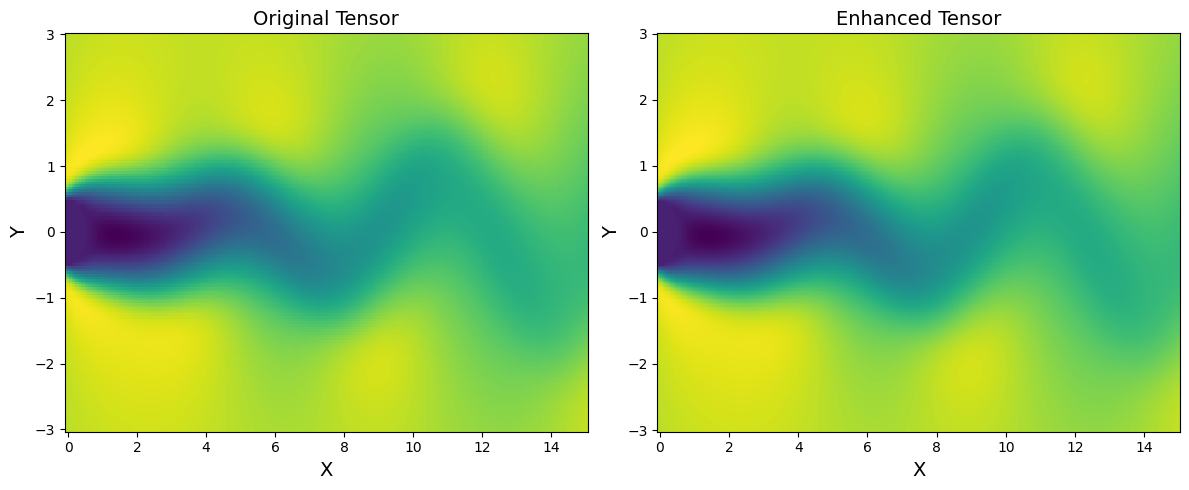

In [8]:
# Plot original vs reconstruction
f = mat73.loadmat('./Test Case/X.mat')
X = f['X']
f = mat73.loadmat('./Test Case/Y.mat')
Y = f['Y']


X_high_res = zoom(X, 2**n, order=1)  # Factor 2^n
Y_high_res = zoom(Y, 2**n, order=1)

component = 0  # First component
original_slice = Tensor[component, :, :, -1]
enhanced_slice = Tensor_high_res[component, :, :,-1]

vmin, vmax = min(original_slice.min(), enhanced_slice.min()), max(original_slice.max(), enhanced_slice.max())

fig_rec, axes_rec = plt.subplots(1, 2, figsize=(12, 5))

# Plot original tensor
im1 = axes_rec[0].pcolor(X,Y,original_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[0].set_title("Original Tensor", fontsize=14)
axes_rec[0].set_xlabel("X", fontsize=14)
axes_rec[0].set_ylabel("Y", fontsize=14)

# Plot reconstructed tensor
im2 = axes_rec[1].pcolor(X_high_res,Y_high_res,enhanced_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[1].set_title("Enhanced Tensor", fontsize=14)
axes_rec[1].set_xlabel("X", fontsize=14)
axes_rec[1].set_ylabel("Y", fontsize=14)

plt.tight_layout()
plt.show()